# Explorations of Cumulant Decompositions

We're going to consider a simple 1D system with a particle connected to two springs that are anchored to $x=-1$ and $x=1$. The system has the Hamiltonian:
\begin{align}
H(x, \lambda) =& \frac{1}{2} k_0 \left[ (x - 1)^2 + (x + 1)^2 \right] +
    \frac{f(\lambda)}{2} (k_1 - k_0) (x - 1)^2 +
    \frac{g(\lambda)}{2} (k_2 - k_0) (x + 1)^2 \\
    =& H_0(x) + \Delta H_1(x, \lambda) + \Delta H_2(x, \lambda).
\end{align}

We will consider the decomposition into the following free energy components:
* $A$: the total free energy
* $A_1$: the change in the total free energy when $\Delta H_1=0$
* $A_2$: the change in the total free energy when $\Delta H_2=0$
* $C_{12}$: the extra change in total free energy when $\Delta H_1 = \Delta H_2 = 0$.

For this simple system, $A_1$ + $A_2$ + $C_{12}$ = $A$.

We will consider the case where $k_1 = k_2$, which implies that $A_1 = A_2$.

# Code

In [1]:
from collections import namedtuple
import random
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as pp
%matplotlib inline

In [2]:
# named tuple to hold energy components
Energy = namedtuple('Energy', 'total H0 H1 H2 unscaled_H1 unscaled_H2 f g df dg dH dH1 dH2')

In [3]:
def compute_energy(x, k0, k1, k2, f, g, lambda_):
    """Compute the energy and its components for a configuration"""
    H0 = 0.5 * k0 * (x - 1)**2 + 0.5 * k0 * (x + 1)**2
    H1 = 0.5 * (k1 - k0) * (x + 1)**2
    H2 = 0.5 * (k2 - k0) * (x - 1)**2
    scale1, d1 = f(lambda_)
    scale2, d2 = g(lambda_)
    scaled_H1 = scale1 * H1
    scaled_H2 = scale2 * H2
    total = H0 + scaled_H1 + scaled_H2
    return Energy(total, H0, scaled_H1, scaled_H2, H1, H2, scale1, scale2, d1, d2, d1*H1 + d2*H2, d1*H1, d2*H2)

## Scaling Functions

We will consider three variations of the scaling functions $f_i(\lambda)$ and $g_i(\lambda)$ for $i \in [1,2,3]$.

In [37]:
def f1(lambda_):
    """Simultaneous scaling"""
    assert lambda_ >= 0 and lambda_ <= 1
    return lambda_, 1.0

g1 = f1

def f2(lambda_):
    """f() first, then g()"""
    assert lambda_ >= 0 and lambda_ <= 1
    if lambda_ <= 0.5:
        return 2.0 * lambda_, 2.0
    else:
        return 1.0, 0.0

def f3(lambda_):
    """g() first, then f()"""
    assert lambda_ >= 0 and lambda_ <=p 1
    if lambda_ >= 0.5:
        return 2.0 * (lambda_ - 0.5), 2.0
    else:
        return 0.0, 0.0
    
g2 = f3
g3 = f2


SyntaxError: invalid syntax (<ipython-input-37-8d8576481065>, line 15)

Our three functions look like this:

In [ ]:
lambdas = np.linspace(0, 1, 100)
pp.subplot(3, 1, 1)
pp.plot(lambdas, [f1(lam) for lam in lambdas])
pp.plot(lambdas, [g1(lam) for lam in lambdas])
pp.subplot(3, 1, 2)
pp.plot(lambdas, [f2(lam) for lam in lambdas])
pp.plot(lambdas, [g2(lam) for lam in lambdas])
pp.subplot(3, 1, 3)
pp.plot(lambdas, [f3(lam) for lam in lambdas])
pp.plot(lambdas, [g3(lam) for lam in lambdas]);

## Monte Carlo

In [5]:
def update(x, k0, k1, k2, f, g, lambda_, steps):
    for step in range(steps):
        x_trial = x + random.gauss(0.0, 0.1)
        e_init = compute_energy(x, k0, k1, k2, f, g, lambda_)
        e_trial = compute_energy(x_trial, k0, k1, k2, f, g, lambda_)
        delta = e_trial.total - e_init.total
        if delta < 0:
            accept = True
        else:
            if random.random() < math.exp(-delta):
                accept = True
            else:
                accept = False
        
        if accept:
            x = x_trial
    return x, compute_energy(x, k0, k1, k2, f, g, lambda_)

In [6]:
def compute_curve(n_points, steps, walk_steps, k0, k1, k2, f, g):
    lambdas = np.linspace(0, 1, n_points)
    position_results = {}
    energy_results = {}
    for lambda_ in lambdas:
        positions = []
        energies = []
        x = 0.0
        for step in range(steps):
            x, energy = update(x, k0, k1, k2, f, g, lambda_, walk_steps)
            positions.append(x)
            energies.append(energy)
        positions = np.array(positions)
        energies = pd.DataFrame(energies)
        position_results[lambda_] = positions
        energy_results[lambda_] = energies
    
    return position_results, energy_results
        

In [7]:
def extract_averages(energies):
    lambdas = list(energies.keys())
    dH = [energies[lam]['dH'].mean() for lam in lambdas]
    dH1 = [energies[lam]['dH1'].mean() for lam in lambdas]
    dH2 = [energies[lam]['dH2'].mean() for lam in lambdas]
    return lambdas, dH, dH1, dH2

In [8]:
def compute_integrals(lambdas, dH, dH1, dH2):
    A = np.trapz(dH, lambdas)
    A1 = np.trapz(dH1, lambdas)
    A2 = np.trapz(dH2, lambdas)
    C12 = A - A1 - A2
    return A, A1, A2, C12

# Constants

In [9]:
STEPS = 25_000

# Naïve Decomposition

## Pathway 1

In [10]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)

In [11]:
lambdas, dH, dH1, dH2 = extract_averages(energies)

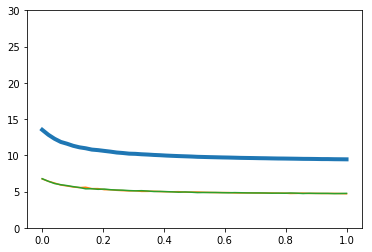

In [12]:
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30);

In [13]:
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

10.1503532952
5.07493287875
5.07542041645
8.881784197e-16


## Pathway 2

In [14]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)

In [15]:
lambdas, dH, dH1, dH2 = extract_averages(energies)

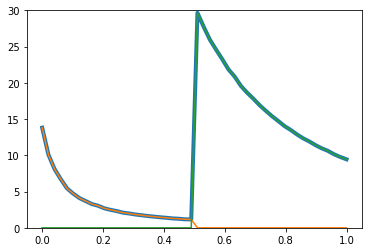

In [16]:
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30);

In [17]:
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

10.1525847259
1.67462680674
8.47795791913
-1.7763568394e-15


## Pathway 3

In [18]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)

In [19]:
lambdas, dH, dH1, dH2 = extract_averages(energies)

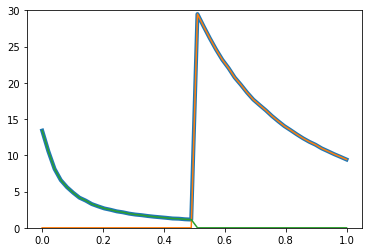

In [20]:
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30);

In [21]:
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

10.1637248604
8.48071627979
1.68300858065
1.33226762955e-15


## Analysis

This makes sense:
* The larger of the two numbers (approx. 8.48) is the difference in the total free energy without that component.
* Since $k_1=k_2$, we should have $A_1 = A_2$, which clearly isn't the case here
* Our expectation is that $A = A_1 + A_2 + C_{12}$, so $C_{12} = A - A_1 - A_2$, which will give $10.15 - 2 \times 8.48 = -6.81$.

The task now is to see if we can make any of these predictions from a single simulation.

# Exponential Reweighting

The code below will use the full exponential weighting scheme. In principle, this is exact, but may have a high variance when estimated due to poor overlap between ensembles and strong dependence between Hamiltonian components.

The components are corrected by:
\begin{equation}
A_1' = \langle H_1' \rangle  + \langle H_2' \rangle - \frac{\langle H_2' e^{H_1} \rangle}{\langle e^{H_1} \rangle}
\end{equation}

In [22]:
def compute_exp_reweight(deriv, energy):
    max_energy = max(energy)
    weights = np.exp(energy - max_energy)
    return np.mean(weights * deriv) / np.mean(weights)

In [23]:
def extract_reweighted_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1w = np.array([compute_exp_reweight(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2w = np.array([compute_exp_reweight(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 + dH2 - dH2w, dH1 + dH2 - dH1w

## Pathway 1

10.1557011391
8.49035326241
8.44896133638
-6.78361345966


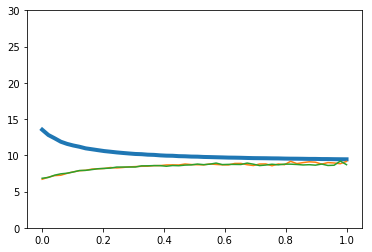

In [24]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)
lambdas, dH, dH1, dH2 = extract_reweighted_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* All three components are close to the expected values. 
* As expected, $A_1$ and $A_2$ are nearly identical.
* There is little noise in $A_1'$ and $A_2'$

## Pathway 2

10.1539376065
7.99140062655
8.4815689115
-6.31903193152


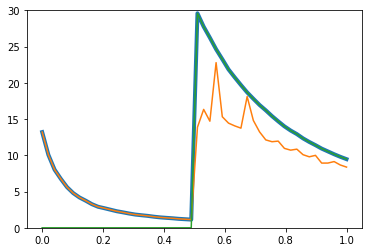

In [25]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)
lambdas, dH, dH1, dH2 = extract_reweighted_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* All three components are close to the expected values, although not quite as close as in the identical case.
* $A_1 \approx A_2$, but not as close as the identical case.
* Curve for $A_1'$ is very noisy due to exponential averaging.

## Pathway 3

10.153029641
8.48231456132
7.80881061866
-6.13809553896


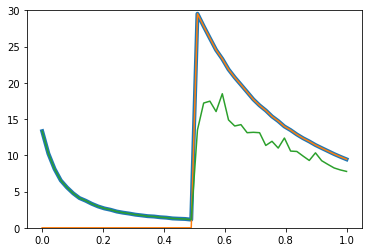

In [26]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)
lambdas, dH, dH1, dH2 = extract_reweighted_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* All three components are close to the expected values, although not quite as close as in the identical case.
* $A_1 \approx A_2$, but not as close as the identical case.
* Curve for $A_2'$ is very noisy due to exponential averaging.

# 1st Order Cumulant

The code below uses the first order cumulant expansion. This is an approximation, because the Taylor series is truncated at first order, but it may be less noisy than the exponential average.

The components are corrected by:
\begin{equation}
A_1' = \langle H_1' \rangle  - \left( \langle H_2' H_1 \rangle - \langle H_2' \rangle \langle H_1 \rangle \right).
\end{equation}

In [27]:
def compute_cum1(deriv, energy):
    return np.mean(deriv * energy) - np.mean(deriv) * np.mean(energy)

In [28]:
def extract_cum1_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1c = np.array([compute_cum1(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2c = np.array([compute_cum1(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 - dH2c, dH2 - dH1c

## Pathway 1

10.1478190871
8.25109934596
8.22961552753
-6.33289578636


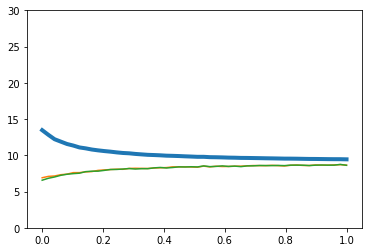

In [29]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)
lambdas, dH, dH1, dH2 = extract_cum1_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* All three components are close to the expected values, although not quite as close with the exponential correction.
* $A_1 = A_2$, as expected

## Pathway 2

10.1461410203
5.85277128976
8.46782099553
-4.17445126496


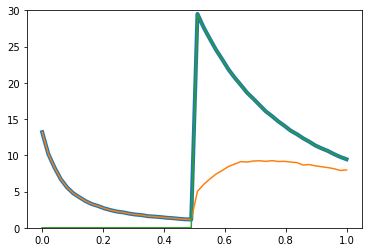

In [30]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)
lambdas, dH, dH1, dH2 = extract_cum1_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* Values are approximately correct, but not as good as in exponential case or 1st-order identical scaling case.
* $A_1 \approx A_2$, but there's still a large difference.
* Result is substantially more accurate than naive.
* $A_1'$ is not very noisy

## Pathway 3

10.1652623263
8.48204201019
5.85586920064
-4.17264888456


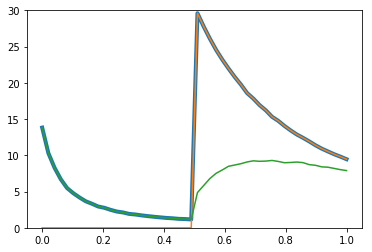

In [31]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)
lambdas, dH, dH1, dH2 = extract_cum1_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

* Values are approximately correct, but not as good as in exponential case or 1st-order identical scaling case.
* $A_1 \approx A_2$, but there's still a large difference.
* Result is substantially more accurate than naive.
* $A_2'$ is not very noisy.

# 2nd Order Cumulant

The code below uses the second order cumulant expansion. This is an approximation, because the Taylor series is truncated at second order, but it may be less noisy than the exponential average. It should be more accurate than the first order expansion, but may be more noisy.

The components are corrected by:
\begin{equation}
A_1' = \langle H_1' \rangle  - \left(\langle H_2' H_1 \rangle - \langle H_2' \rangle \langle H_1 \rangle\right)
    - \frac{1}{2}\left(
        \langle H_2' H_1^2 \rangle
        - 2 \langle H_2' H_1 \rangle \langle H_1\rangle
        - \langle H_2'\rangle \langle H_1^2 \rangle
        + 2 \langle H_2' \rangle \langle H_1 \rangle^2
    \right).
\end{equation}

In [32]:
def compute_cum2(deriv, energy):
    return compute_cum1(deriv, energy) + 0.5 * (
        np.mean(deriv * energy**2) -
        2 * np.mean(deriv * energy) * np.mean(energy) -
        np.mean(deriv) * np.mean(energy**2) +
        2 * np.mean(deriv) * np.mean(energy)**2
    )

In [33]:
def extract_cum2_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1c = np.array([compute_cum2(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2c = np.array([compute_cum2(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 - dH2c, dH2 - dH1c

## Pathway 1

10.1568911005
8.85735417342
8.85200067543
-7.55246374835


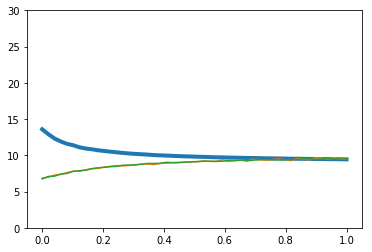

In [34]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)
lambdas, dH, dH1, dH2 = extract_cum2_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

## Pathway 2

10.1486455008
7.63145699644
8.47683361497
-5.95964511063


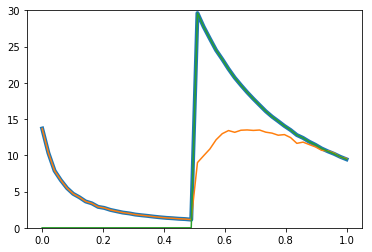

In [35]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)
lambdas, dH, dH1, dH2 = extract_cum2_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)

## Pathway 3

10.1664243705
8.48118192991
7.66277697162
-5.97753453105


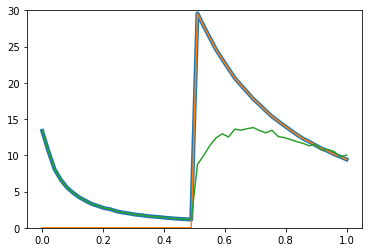

In [36]:
positions, energies = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)
lambdas, dH, dH1, dH2 = extract_cum2_averages(energies)
pp.plot(lambdas, dH, linewidth=4)
pp.plot(lambdas, dH1)
pp.plot(lambdas, dH2)
pp.ylim(0, 30)
A, A1, A2, C12 = compute_integrals(lambdas, dH, dH1, dH2)
print(A)
print(A1)
print(A2)
print(C12)